# Environment Setup

In [1]:
import time
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

env_name = 'MountainCar-v0'

In [2]:
# env = gym.make(env_name, render_mode='human')
# env.reset()

# for step in range(250):

#     env.render()
    
#     action = env.action_space.sample()
#     observation, reward, done, trunc, info = env.step(action)

#     time.sleep(0.001)
    
#     if done:
#         env.reset()
#         break

# env.close()

# Hyperparameter Initialization

In [3]:
def create_observation_bins(num_bins_per_observation=10):
    bins_car_position = np.linspace(-1.2, 0.6, num_bins_per_observation)
    bins_car_velocity = np.linspace(-0.07, 0.07, num_bins_per_observation)

    bins = np.array([bins_car_position, bins_car_velocity])
    
    return bins

In [4]:
NUM_BINS = 40
BINS = create_observation_bins(NUM_BINS)

In [5]:
def discretize_observation(observations, bins):

    binned_observations = []

    for i, observation in enumerate(observations):
        # observations is in [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
        # our bins were organized in the same way, thus observation[0] corresponds to bins[0]
        discretized_observation = np.digitize(observation, bins[i])

        binned_observations.append(discretized_observation)

    return tuple(binned_observations)

In [6]:
env = gym.make(env_name, render_mode='rgb_array')
observation, _ = env.reset()
print(f'Raw (continuous) observation: {observation}')
mapped_observation = discretize_observation(observation, BINS)
print(f'Mapped (discrete) observation: {mapped_observation}')

Raw (continuous) observation: [-0.4310665  0.       ]
Mapped (discrete) observation: (17, 20)


In [7]:
q_table_shape = (NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)
print(q_table.shape)

(40, 40, 3)


In [8]:
EPISODES = 20000 
ALPHA = 0.8
GAMMA = 0.95

In [9]:
epsilon = 1.0

# To try a linear reduction based on episodes
BURN_IN = 1
EPSILON_END = 10000
EPSILON_REDUCE = 0.0001

# To try an exponential reduction
MAX_EPSILON = 1.0
MIN_EPSILON = 0.01
DECAY_RATE = 0.01

# Update Functions

In [10]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    """
        Explaining Epsilon-Greedy Logic: 
        Since epsilon starts at 1.0, and our random number generator doesn't include 1.0 and
        we're using an exponential decay function for our epsilon, for the beginning we will 
        be mostly exploring a lot (AKA choosing the random action). However, as epsilon gets
        smaller over time, we will be exploiting what we've learned more and more, and exploring
        only very little.
    """

    random_number = np.random.random()

    # EXPLOITATION (choose the action that maximizes Q)
    if random_number > epsilon:

        # For the given (discrete) state, grab that state,
        # minor change from the previous example 
        # where we wanted the whole row, and we still
        # grab the index of the highest value
        action = np.argmax(q_table[discrete_state])
        
    # EXPLORATION (choose a random action)
    else:
        action = env.action_space.sample()

    return action

In [11]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    """
        Q-Learning Update Equation
    """
    return old_q_value + ALPHA*(reward + GAMMA*next_optimal_q_value - old_q_value)

In [12]:
def reduce_epislon(epsilon, episode, mode='linear'):
    """
        A function to reduce epsilon
        With the option to use either:
        A linear function with a burn-in factor
        or an exponential function
    """
    if mode == 'linear':
        if BURN_IN <= episode <= EPSILON_END:
            epsilon -= EPSILON_REDUCE
    if mode == 'exponential':
        epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON)*np.exp(-DECAY_RATE*episode)

    return epsilon

In [13]:
def reward_modifier(reward, truncated, position, episode):
    if not truncated and (position < -0.4 or position > -0.2) and episode < 5000:
        reward += 1
    return reward

# Agent Training & Visualization

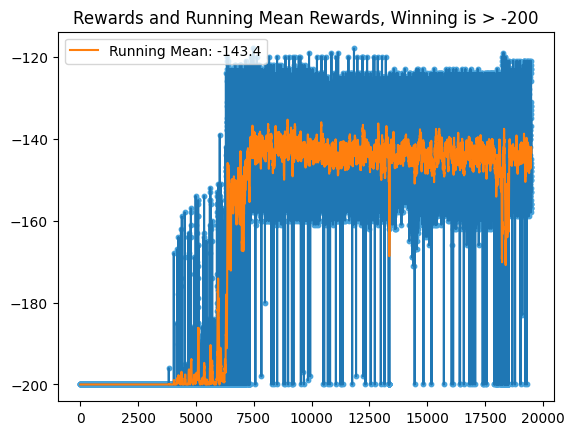

In [15]:
# Reinitialize the environment to render_mode='rgb_array' so that it's not wasting time rendering the game
env = gym.make(env_name, render_mode='rgb_array')

# For game visualization
# render_interval = 30000

# For plotting purposes
log_interval = 500 
points_log = []
mean_points_log = []
episodes = []

# Start training the Agent
for episode in range(EPISODES):
    # print(f'{episode} / {EPISODES}')
    
    # Initialize everyting
    initial_state = env.reset()[0]
    discretized_state = discretize_observation(initial_state, BINS)
    done = False
    truncated = False
    points = 0
    episodes.append(episode)
    # start_time = time.time()
    # time_step = 0
    # Play the game
    while not done and not truncated:

        # print(f'Time-Step: {time_step}')
        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)
        next_state, reward, done, truncated, _ = env.step(action)

        # Let's just try modifying the reward a tiny bit 
        # reward = reward_modifier(reward, truncated, next_state[0], episode)
        
        # We need to make the next state discrete
        next_discretized_state = discretize_observation(next_state, BINS)

        # Grab the old (current) Q value
        old_q_value = q_table[discretized_state + (action,)]

        # Grab the max (optimal) Q value from the table
        next_optimal_q_value = np.max(q_table[next_discretized_state])

        # Compute the next Q value
        next_q_value = compute_next_q_value(old_q_value, reward, next_optimal_q_value)

        # Add it to the table
        q_table[discretized_state + (action,)] = next_q_value

        # Set move forward by updating the state
        discretized_state = next_discretized_state
        points -= 1
        # time_step += 1

    # print(f'Time taken: {(time.time() - start_time)}')
    epsilon = reduce_epislon(epsilon, episode, mode='linear')
    points_log.append(points)
    # Grabs the last 30 points in points_log and takes the average up to 2 decimal points
    running_mean = round(np.mean(points_log[-30:]), 2)
    mean_points_log.append(running_mean)

    if episode % log_interval == 0:
        clear_output(wait=True)
        plt.title('Rewards and Running Mean Rewards, Winning is > -200')
        plt.scatter(episodes, points_log[:len(episodes)], s=10, c='#47A3DC')
        plt.plot(episodes, points_log[:len(episodes)])
        plt.plot(episodes, mean_points_log[:len(episodes)], label=f'Running Mean: {running_mean}')
        plt.legend()
        plt.show()
    
env.close()

In [16]:
env = gym.make(env_name, render_mode='human')
observation = env.reset()[0]
rewards = 0

for step in range(1000):
    env.render()
    discrete_state = discretize_observation(observation, BINS)
    action = np.argmax(q_table[discrete_state])
    observation, reward, done, truncated, _ = env.step(action)
    rewards -= 1
    if done or truncated:
        print(f"Total Rewards: {rewards}")
        break
        
env.close()

Total Rewards: -137


# Best Results:
Bins: 40 <br>
Epsilon Reduce: 'linear' <br>
Reward Modifier: False <br>
Maximum Q Value Selection Reward: -142 <br><br>

# Other Results:
Bins: 40 <br>
Epsilon Reduce: 'exponential' <br>
Reward Modifier: False <br>
Maximum Q Value Selection Reward: -200 <br><br>

Bins: 40 <br>
Epsilon Reduce: 'linear' <br>
Reward Modifier: True <br>
Maximum Q Value Selection Reward: -191 <br><br>
